[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fvalerii/geospatial-land-classification/blob/main/notebooks/02_cnn_development/04_keras_cnn_classifier.ipynb)

# 🛰️ 04: Baseline CNN Architecture & Optimization (Keras)
### Geospatial Land Classification Study (Keras Phase)
(*This is the 4th module in a 9-part series exploring geospatial hybrid models.*)

### 🧪 Methodology & Technical Objectives
This research module establishes the **supervised learning baseline** using a custom Convolutional Neural Network (CNN) architecture. We focus on the design of a feature extraction pipeline capable of identifying spatial patterns in $64 \times 64$ satellite tiles.

**Key Technical Focus:**
* **Architecture Design:** Implementation of a multi-stage CNN featuring `Conv2D`, `BatchNormalization`, and `Dropout` layers for robust feature extraction.
* **Optimization Strategy:** Leveraging the `Adam` optimizer with `BinaryCrossentropy` to minimize objective loss on the agricultural classification task.
* **Performance Benchmarking:** Establishing reference metrics (Accuracy, Loss) to evaluate the relative gains of later Transformer-based integrations.

## Introduction

This module develops a **deterministic baseline** for the binary classification of agricultural terrain. By utilizing a stack of convolutional kernels, we aim to capture local spatial hierarchies within the imagery. This model serves as the primary benchmark for the comparative analysis in **Module 06** and the subsequent **Hybrid CNN-ViT Integration (Module 09)**.

## Table of Contents
<font size = 3> 

1. [Implementation Environment & Dependency Management](#Implementation-Environment-&-Dependency-Management)
2. [Data Ingestion & Transformation Pipeline](#Data-Ingestion-&-Transformation-Pipeline)
3. [CNN Architecture Design](#CNN-Architecture-Design)
4. [Model-Checkpoint-acllback](#Model-Checkpoint-Callback)
5. [Model Training](#Model-Training)
6. [Model Evaluation and Visualization](#Model-Evaluation-and-Visualization)

</font>


## Implementation Environment & Dependency Management

In [1]:
import os, sys

# --- Universal Environment Setup ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Use the fast local runtime disk for satellite imagery
    BASE_DIR = '/content/'
    os.chdir(BASE_DIR)
    
    # Install specific versions for vit-research environment stability
    !pip install numpy==1.26.0 matplotlib==3.9.2 pandas==2.2.3 tensorflow==2.19\
        scikit-learn==1.7.0 requests tqdm==4.66.5 Pillow --quiet
    
    print(f"✅ Environment: Google Colab. In-memory data loading will use: {BASE_DIR}")
else:
    # Local System (relative to the notebook folder)
    BASE_DIR = './' 
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

✅ Environment: Local System. Directory: /home/ml/projects/GitHub/notebooks/02_cnn_development


In [2]:
# Set up a quiet environment for TensorFlow and Keras operations
import warnings, logging

# --- 1. System & Library Silence ---
# '3' to only display error messages from its C++ backend.
# This reduces verbose output and keeps the console cleaner, focusing on more critical information during model training.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# '0' disables verbose logging about optimizations and precision details.
os.environ['TF_CPP_MAX_VLOG_LEVEL'] = '0' 
# "0" to disable Intel oneDNN optimizations, which can sometimes lead to issues or unwanted behavior on specific hardware configurations.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 

# --- 2. Python Warning Suppression ---
# Ignore standard warnings (e.g., deprecated functions in TFP or Matplotlib).
warnings.filterwarnings('ignore')

### Framework & Optimization Utilities

Here is a brief description of the usage of the **Keras** libraries and methods that will be used:
- `Sequential` models are a linear stack of layers.
- `Conv2D` and `MaxPooling2D` are fundamental for CNNs, extracting features and reducing dimensionality.
- `BatchNormalization` stabilizes training.
- `Dense` layers form the classifier.
- `Dropout` regularizes to prevent overfitting.
- `Adam` is an adaptive learning rate optimizer.
- `ImageDataGenerator` automates data loading and augmentation.
- `HeUniform` is used for weight initialization.


**Scikit-learn** (`sklearn.metrics`) provides the following metrics for model performance assessment: 
- `classification_report`
- `confusion_matrix`
- `accuracy_score`

In [ ]:
%%time
# --- Common Imports ---
import time
import requests, tarfile, glob
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- TensorFlow and Keras Imports ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
print("Succesfully imported the libraries")

### Hardware Acceleration & GPU Utilization
Check the availability of GPU

In [4]:
# GPU Detection and Specification
# 1. Check if TensorFlow detects the GPU
device_name = tf.test.gpu_device_name()

if not device_name:
    print('❌ GPU device not found.')
    print('💡 Recommendation: If in Colab, go to Runtime > Change runtime type and select "T4 GPU" for significantly faster training.')
else:
    print(f'✅ Found GPU at: {device_name}')

    # 2. Identify the specific GPU model ONLY if detected
    print('\nHardware Specifications:')
    !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

✅ Found GPU at: /device:GPU:0

Hardware Specifications:


I0000 00:00:1770677574.050331   30872 gpu_device.cc:2019] Created device /device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3070 Laptop GPU, 591.44, 8192 MiB


### Reproducibility with random seeds

The random seeds for `random` module, NumPy, and TensorFlow are assigned a fixed value. By initializing these seeds with a constant value (for example, 42), any operations that involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experimental results and when comparing different models or hyperparameters.


In [5]:
# Define a function to set seeds for reproducibility
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    
    Args:
        seed (int): The seed value to use for all random number generators.

    Returns:
        None
    """
    # 1. Set Python core random seed
    random.seed(seed)

    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)

    # 4. Set TensorFlow seed (used for weight initialization)
    tf.random.set_seed(seed)

    # 5. Force TensorFlow to use deterministic algorithms (Optional)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(42)

Reproducibility set with seed: 42


## Data Ingestion & Transformation Pipeline
The dataset is fetched directly from the public IBM Cloud Object Storage. To ensure local reproducibility and bypass proprietary library dependencies, a standard Python pipeline using `requests` and `tarfile` is implemented for automated artifact retrieval and decompression.

In [6]:
# --- Data Ingestion Configuration ---
# Matches your existing path logic: base_dir = os.path.join(extract_dir, 'images_dataSAT')
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"
TAR_FILE = os.path.join(BASE_DIR, "images-dataSAT.tar")
# For simplicity extract to the base directory.
EXTRACT_PATH = BASE_DIR

def download_and_extract(url, destination, extract_to):
    """
    Handles automated retrieval and decompression. 
    Optimized to land data directly into the project root.

    Args:
        - url (str): The URL to download the dataset from.
        - destination (str): The local file path where the downloaded archive will be saved.
        - extract_to (str): The directory where the contents of the archive will be extracted.
    
    Returns:
        None
    """
    # 1. Streamed Download
    if not os.path.exists(destination):
        print(f"🛰️ Downloading archive to: {destination}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, "wb") as f, tqdm(
            desc="Downloading Dataset",
            total=total_size,
            unit='iB', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
    else:
        print(f"✅ Archive already exists.")

    # 2. Extraction 
    expected_folder = os.path.join(extract_to, 'images_dataSAT')
    if not os.path.exists(expected_folder):
        print(f"📦 Extracting dataset to: {extract_to}")
        with tarfile.open(destination, "r") as tar:
            tar.extractall(path=extract_to)
        print("🚀 Extraction complete.")
    else:
        print(f"✅ Dataset folder '{expected_folder}' already verified.")

# Run the ingestion
download_and_extract(DATA_URL, TAR_FILE, EXTRACT_PATH)

🛰️ Downloading archive to: ./images-dataSAT.tar


📦 Extracting dataset to: ./
🚀 Extraction complete.


### 📂 Directory Hierarchy and Class Mapping. The dataset follows a standard categorical sub-directory structure, enabling automated class inference for agricultural and non-agricultural classification.

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.

In [7]:
# Define directories
dataset_path = os.path.join(EXTRACT_PATH, 'images_dataSAT')
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(dataset_path, 'class_0_non_agri')
dir_agri = os.path.join(dataset_path, 'class_1_agri')

print(f"Dataset path: {dataset_path}")
print(f"Non-agricoltural images directory: {dir_non_agri}")
print(f"Agricoltural images directory: {dir_agri}")

Dataset path: ./images_dataSAT
Non-agricoltural images directory: ./images_dataSAT/class_0_non_agri
Agricoltural images directory: ./images_dataSAT/class_1_agri


### Dataset file list creation

A list **`fnames`** of all image files is created by recursively walking through the `dataset_path` using `os.walk` function. 

The total count of files found is printed and the first two and last two file paths are displayed for verifcation purposes. 

The absolute path is captured using `os.path.join(dirname, filename)` and used in `ImageDataGenerator` later.


In [8]:
# Create pandas dataframe of images file paths and corresponding labels
files = glob.glob(f"{dataset_path}/**/*.jpg", recursive=True)
df = pd.DataFrame({
    "filename": [os.path.relpath(f, dataset_path) for f in files],
    "class": [os.path.basename(os.path.dirname(f)) for f in files]
})

# Print count of files found and some examples of files
print(f'Total files in dataset: {len(df)}')
print(f'First two paths:\n {df.iloc[:2, 0]}\n')
print(f'Last two paths:\n {df.iloc[-2:, 0]}\n')


Total files in dataset: 6000
First two paths:
 0    class_1_agri/tile_S2A_MSIL2A_20250427T101701_N...
1    class_1_agri/tile_S2A_MSIL2A_20250427T101701_N...
Name: filename, dtype: object

Last two paths:
 5998    class_0_non_agri/tile_S2A_MSIL2A_20250427T1017...
5999    class_0_non_agri/tile_S2A_MSIL2A_20250427T1017...
Name: filename, dtype: object



In [9]:
# Split train, validation and test dataframes 80/10/10
train_val_df, test_df = train_test_split(
    df, test_size=0.10, random_state=42, stratify=df["class"]
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.111, random_state=42, stratify=train_val_df["class"]
)

### Definition of model hyperparameters

This cell initializes several key **hyperparameters** that will govern the training process and the model's input. Here is the list of hyperparameters:

1. `img_w` and `img_h` defines the width and height for resizing input images.
2.  `n_channels` defines the number of color channels (3 for RGB)
2. `n_epochs` sets the total training iterations over the dataset.
2. `batch_size` sets the number of samples processed per batch in the epoch.
3. `lr` defines the learning rate for the optimizer.
4. `steps_per_epoch` are total number of steps used for training. **None** means the number is calculated automatically.
5. `validation_steps` are total number of steps used for validating the model on validation data. **None** means the number is calculated automatically.

These hyperparameters are crucial for controlling model performance and resource utilization and significantly influence a model's performance and training efficiency. 

In [10]:
# Image dimensions and channels for model input
img_w, img_h = 64, 64
n_channels = 3

n_epochs = 20
batch_size =128
lr = 0.001 # Learning rate
steps_per_epoch = None
validation_steps = None 

model_name = "keras_best_model.keras"

### Implementation of `ImageDataGenerator` for Augmentation


In this section of the code `ImageDataGenerator` is instantiated and configutred with data augmentation parameters:

- `rescale=1./255` normalizes pixel values to [0, 1].
- `rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, and `zoom_range` define random transformations to apply to images during training, increasing dataset diversity.
- `horizontal_flip=True` enables random horizontal mirroring.
- `fill_mode='nearest'` specifies how new pixels are filled after transformations.


This setup boosts model robustness against variations in real-world images. `ImageDataGenerator` performs these transformations on-the-fly, making it efficient for large datasets. 


In [11]:
# --- Data Augmentation Configuration ---
train_datagen = ImageDataGenerator(rescale=1./255, # Nornamlize pixel values to [0, 1]
                             rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest"
                            )

test_datagen = ImageDataGenerator(rescale=1./255)

### Initialization of training, validation, and test data generators

 `flow_from_dataframe()` is a convenient method of `ImageDataGenerator` for automatically creating data pipelines from a pandas dataframe.

 The generator resize images to `(img_w, img_h)` and group them into `batch_size` chunks. `class_mode="binary"` indicates a two-class classification task. 
 

In [12]:
# Initialize the training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=dataset_path,
    x_col="filename", y_col="class",
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary"
)

Found 4800 validated image filenames belonging to 2 classes.


In [13]:
# Initialize the validation data generator
validation_generator = test_datagen.flow_from_dataframe(
    val_df, directory=dataset_path,
    x_col="filename", y_col="class",
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary"
)

Found 600 validated image filenames belonging to 2 classes.


In [14]:
# Initialize the test data generator
test_generator = test_datagen.flow_from_dataframe(
    test_df, directory=dataset_path,
    x_col="filename", y_col="class",
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 600 validated image filenames belonging to 2 classes.


## CNN Architecture Design

The model architecture is composed of several key components:
- **`Sequential`** is a linear stack of layers in Keras.
- **Conv2D** layers perform convolution operations, acting as feature detectors.
- **MaxPooling2D** reduces the spatial dimensions of the feature maps.
-  **BatchNormalization** mitigates internal covariate shift and accelerates convergence.
-  **GlobalAveragePooling2D** summarizes feature maps into a single vector, reducing parameters.
-  **Dense** (fully connected) layers learn complex patterns from these features.
-  **Dropout** stochastic regularization technique to prevent co-adaptation of features and mitigate overfitting.
-  **Sigmoid** activation is used for binary classification, mapping outputs to probabilities.
-  **HeUniform** optimal weight initialization strategy for layers using ReLU activation functions.
-  **The final output `Dense` layer** uses a `sigmoid` activation for binary classification, outputting a probability between 0 and 1.

In [15]:
# Build a CNN model with 6 Conv2D Layers and 6 Dense Layers with Batch Normalization and Dropout for reguarization
model = Sequential([
                    # Convolutional Block 1
                    # Convolutional layers with increasing filter sizes, followed by max pooling and batch normalization
                    Conv2D(32 , (5,5) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
                    MaxPooling2D(2,2), # Reduce each spatial dimension by a factor of 2 (e.g., 64x64 -> 32x32)
                    BatchNormalization(), # Normalize layer outputs to stabilize training and improve convergence
                    
                    Conv2D(64, (5,5) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(128, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    ###
                    Conv2D(256, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(512, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(1024, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    
                    ###
                    # Global average pooling to reduce the spatial dimensions to 1x1 while retaining the depth (number of filters) information.
                    GlobalAveragePooling2D(),
                    
                    # Fully Connected Layers with Dropout and Batch Normalization
                    Dense(64,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(128,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(256,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    ###
                    Dense(512,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(1024,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(2048,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    
                    ###
                    # Final output Layer with sigmoid activation for bynary classification
                    Dense(1 , activation="sigmoid")
                    
                ])

I0000 00:00:1770677580.586402   30872 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Model compilation and architecture display


The model is compiled using `model.compile()` with the `Adam` optimizer and `learning_rate` equal to `lr` (0.001). 

The `loss` function is specified as `"binary_crossentropy"`, appropriate for binary classification problems. 
`accuracy` is set as the performance `metric` to monitor training and evaluation. 
A detailed overview of the network is printed with `model.summary()`. 


In [16]:
loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),
              loss=loss, 
              metrics=["accuracy"])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,352,897 (77.64 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

None


Architectural Note: The model utilizes a Pyramidal Feature Extraction strategy, where the number of filters doubles ($32 \to 64$) as spatial resolution decreases, capturing increasingly complex geometric features from the satellite tiles.

## Model Checkpoint Callback

A `callback` method was created to save the **best model** during training. The best model can be defined by either **lowest loss** or **high accuracy**.


In [17]:
# Create the ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                monitor='val_loss',      # or 'val_accuracy'
                                mode='min',              # 'min' for loss, 'max' for accuracy
                                save_best_only=True,
                                verbose=1
                               )

Alternative checkpoint callback definition  with **maximum accuracy**. 


In [18]:
# Create model checkpoint based on maximum validation accuracy
checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                    monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True,
                                    verbose=1
                                   )


## Model Training

### Display the training configuration and hyperparameters

Comprehensive summary of the training configuration where all critical hyperparameters are listed. This detailed output serves as a quick reference and verification of the experimental setup.
Before commencing computationally intensive tasks such as deep learning model training, it's a good practice to log and verify the configuration.

In [19]:
print(f"Training Hyperparameters:\n\
        n_classes (train) = {len(train_generator.class_indices)},\n\
        n_classes (validation) = {len(validation_generator.class_indices)},\n\
        img_w, img_h ={img_w, img_h},\n\
        n_channels = {n_channels},\n\
        batch_size = {batch_size},\n\
        steps_per_epoch = {steps_per_epoch},\n\
        n_epochs = {n_epochs},\n\
        validation_steps = {validation_steps},\n\
        learning_rate = {lr}")

Training Hyperparameters:
        n_classes (train) = 2,
        n_classes (validation) = 2,
        img_w, img_h =(64, 64),
        n_channels = 3,
        batch_size = 128,
        steps_per_epoch = None,
        n_epochs = 20,
        validation_steps = None,
        learning_rate = 0.001


### Implementation: model training

- `model.fit()` is the primary function for training a Keras model. It controls the entire training loop: iterating over epochs, fetching data batches from generators, performing forward and backward passes, updating weights via the optimizer, and calculating loss and metrics.
- `steps_per_epoch` (*if specified*) determines how many batches constitute an "epoch."
- `validation_data` and `validation_steps` allow monitoring of the model's generalization ability on a separate dataset, helps in detecting overfitting.
- `callbacks` determines how the best model is saved.
- The `fit` object stores the model's training history.


In [20]:
# Train the model with the checkpoint callback
print(f"Training on : ==={device_name}=== with batch size: {batch_size} & lr: {lr}")

fit = model.fit(train_generator, 
                epochs= n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=(validation_generator),
                validation_steps = validation_steps,
                callbacks=[checkpoint_cb],
                verbose=1
               )

Training on : ===/device:GPU:0=== with batch size: 128 & lr: 0.001
Epoch 1/20


I0000 00:00:1770677587.604576   33068 cuda_dnn.cc:529] Loaded cuDNN version 90600


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7292 - loss: 0.6382
Epoch 1: val_accuracy improved from None to 0.57167, saving model to keras_best_model.keras

Epoch 1: finished saving model to keras_best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.8587 - loss: 0.3837 - val_accuracy: 0.5717 - val_loss: 17.7621
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9629 - loss: 0.1437
Epoch 2: val_accuracy did not improve from 0.57167
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9598 - loss: 0.1532 - val_accuracy: 0.3400 - val_loss: 16.2115
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9662 - loss: 0.1330
Epoch 3: val_accuracy did not improve from 0.57167
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9663 - loss: 0.1165 - val_accuracy: 0.4900 - val_loss: 5.2364
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9678 - loss: 0.0991
Epoch 4: val_accuracy improved from 0.57167 to 0.68667, savin

After the training is completed, a `keras_best_model.keras` is saved in a directory with the name of the model.

### Training visualization

The next two cells generate two plots to visualize the model's training performance for accuracy and loss across epochs. 
- **Accuracy** measures the proportion of correct predictions. 
- **Loss** quantifies the error between predictions and true labels. 
- Using these metrics, we can check the model for **overfitting** or **underfitting**. 
- `fit.history` attribute stores these metrics for each epoch.


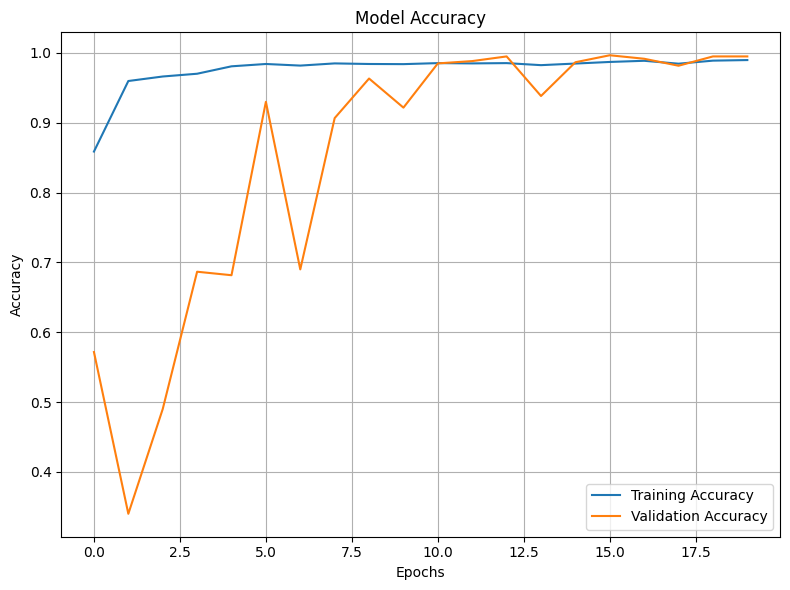

In [21]:
# Create a figure with a single subplot for Accuracy
fig, axs = plt.subplots(figsize=(8, 6))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history['val_accuracy'], label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

Graph of **training loss** and **validation loss** for the model `fit`.


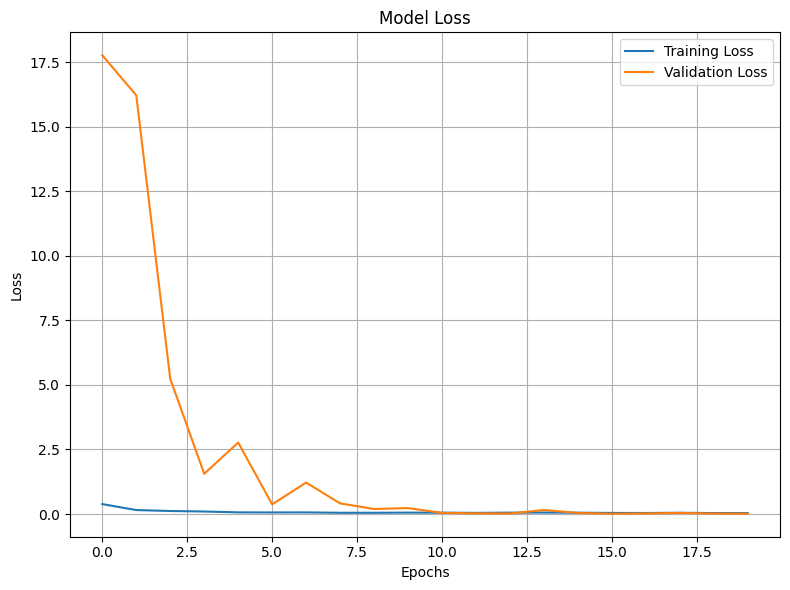

In [22]:
## Plot training and validation loss
fig, axs = plt.subplots(figsize=(8, 6))

# Plot Accuracy on the first subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

## Model Evaluation and Visualization


An evaluation of the trained model is performed on the test dataset,  by comparing the true class labels (`y_true`) and the model's predictions (`y_pred`) on the holdout set. The predicted probabilities are converted to binary class labels using a 0.5 threshold. The overall `accuracy_score` has been used to get a  quantitative assessment of the model's performance on unseen data.

Model evaluation metrics are essential for understanding a model's generalization ability. `y_true` represents the actual labels, while `y_pred` are the model's predicted labels. For binary classification, probabilities are converted to class labels by thresholding. The **accuracy score** is the proportion of correct predictions out of the total predictions.


In [23]:
# Define parameters for evaluation
# We need to calculate the number of steps to ensure we evaluate on the entire validation set.
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
batch_size = int(test_generator.batch_size)

all_preds = []
all_labels = []
for step in range(steps):
    # Get one batch data
    images, labels = next(test_generator)
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten() 
    all_preds.extend(preds)
    all_labels.extend(labels)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy Score: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Accuracy Score: 0.9950


---
**Module 04 Conclusion:** This module successfully established the Keras-based CNN baseline. By implementing a deep feature extractor with integrated regularization (`Dropout`, `BatchNormalization`), we achieved a stable training curve. 

The resulting weights are persisted as a `.keras` artifact, which will be utilized in **Module 06** for cross-framework benchmarking and in **Module 09** as the pre-trained feature extraction backbone for our **Hybrid CNN-ViT Study**.